In [57]:
import numpy as np
import matplotlib.pyplot as plt
import rospkg
from stl import mesh
from mpl_toolkits import mplot3d
import matplotlib.patches as patches
import cv2
rospack = rospkg.RosPack()


In [19]:
MESH_DIR = rospack.get_path('catbot_pybullet') + '/world_mesh/'
MESH_NAME = 'room.stl'

In [20]:
def getVertices(mesh):
    return np.around(np.unique(mesh.vectors.reshape([int(mesh.vectors.size/3), 3]), axis=0),2)

world_mesh     = mesh.Mesh.from_file(MESH_DIR + MESH_NAME)
world_vertices = getVertices(world_mesh)


/tmp/ipykernel_54931/173807171.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axes = figure.gca(projection='3d', proj_type = 'ortho')


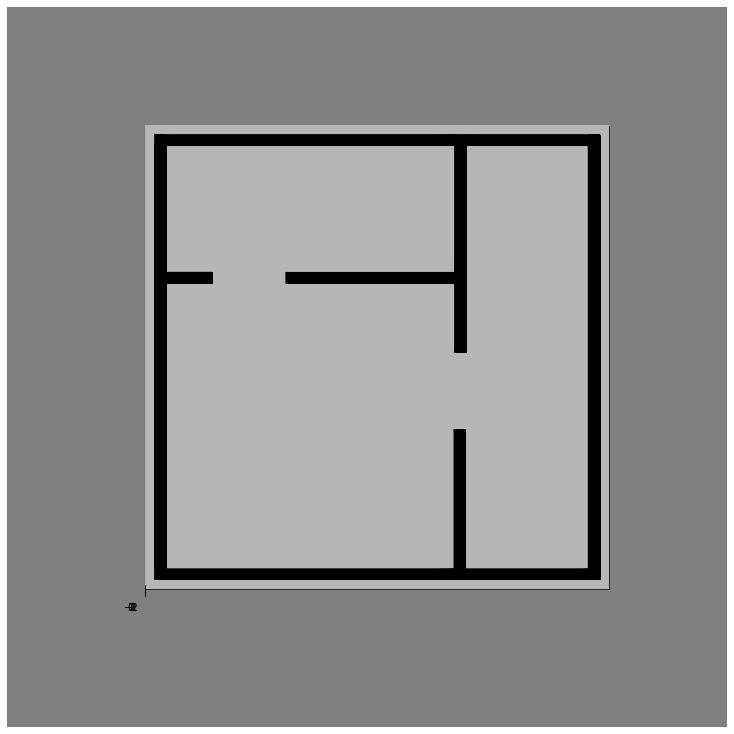

In [56]:
# Create a new plot
figure = plt.figure(figsize = (10,10))
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1)
axes = figure.gca(projection='3d', proj_type = 'ortho')


axes.add_collection3d(mplot3d.art3d.Poly3DCollection(world_mesh.vectors, color='black'))
scale = world_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)

axes.view_init(elev=90., azim=0)
axes.set_xticks([])
axes.set_yticks([])



axes.spines.right.set_visible(False)
axes.spines.top.set_visible(False)
axes.spines.left.set_visible(False)
axes.spines.bottom.set_visible(False)

x_lim = np.array([np.min(world_vertices[:,0]), np.max(world_vertices[:,0])])
y_lim = np.array([np.min(world_vertices[:,1]), np.max(world_vertices[:,1])])


axes.set_xlim(x_lim)
axes.set_ylim(y_lim)


axes.set_facecolor((0.5,0.5,0.5))

plt.savefig('top_view_model.png', dpi = 100, format = 'png')

CatBot Lab Context: This notebook supports the CatBot course and focuses on Generate map.

# Generate map

Note: This lab uses a generated top-view room map stored as `top_view_model.png`.

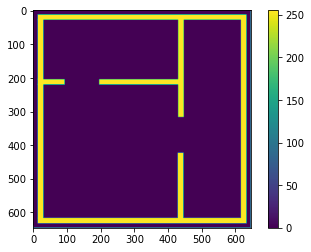

In [90]:
def getCutImg(img, val = 128, range_val = 5):
    mid_x = img.shape[0]//2
    mid_y = img.shape[1]//2
    
    valid_ix_x = np.where(img[:,mid_y] != val )[0]
    valid_ix_y = np.where(img[mid_x,:] != val)[0]
    
    img_x = img[valid_ix_x, :]
    
    return img_x[:, valid_ix_y]
    
   
img = cv2.imread('top_view_model.png')[:,:,0]
img = 255-getCutImg(img)
img[img < 255] = 0



plt.imshow(img)
plt.colorbar()

### Low resolution

(24, 24)


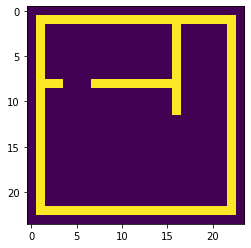

In [138]:
from scipy import ndimage

zoom_factor = 0.037 # Try minimum zoom factor

img_lr = ndimage.zoom(img, zoom = zoom_factor)
img_lr[img_lr > 0] =1
plt.imshow(img_lr)
print(img_lr.shape)

In [139]:
img_lr[1,1]

1

# get lines

In [158]:
def wall_exists(walls, wall):
    if wall is None:
        return True
    
    for w in walls:
        if np.array_equal(w, wall):
            return True
    return False

def getWall(img_lr, starting_pos, wall_type = 'horizontal'):
    starting_pos = np.array(starting_pos, dtype = np.int32)
    
    
    if img_lr[starting_pos[0], starting_pos[1]] == 0:
        return None
    
    origin_pos = starting_pos.copy()
    end_pos    = starting_pos.copy()
    
    step = np.array([1,0], dtype = np.int32)
    if wall_type == 'vertical':
        step = np.array([0,1], dtype = np.int32)

    #move in one direction
    while True:
        next_pos = origin_pos - step
        if img_lr[next_pos[0], next_pos[1]] == 0:
            break
        origin_pos = next_pos
    
    #move in oposite direction
    while True:
        next_pos = end_pos + step
        if img_lr[next_pos[0], next_pos[1]] == 0:
            break
        end_pos = next_pos
    
    if np.linalg.norm(end_pos - origin_pos) == 0:
        return None
    
    return np.array([origin_pos, end_pos])
        

    
walls = []

for i in range(img_lr.shape[0]):
    for j in range(img_lr.shape[1]):
        wall_h = getWall(img_lr, [i,j], wall_type = 'horizontal')
        if not wall_exists(walls, wall_h):
            walls.append(wall_h)
        
        wall_v = getWall(img_lr, [i,j], wall_type = 'vertical')
        if not wall_exists(walls, wall_v):
            walls.append(wall_v)        

            
walls = np.array(walls)

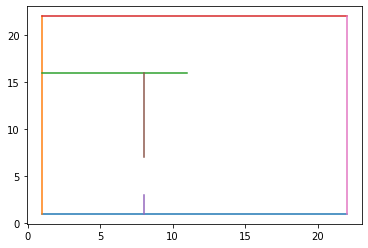

In [159]:
for wall in walls:
    plt.plot(wall[:,0], wall[:,1])

### Center

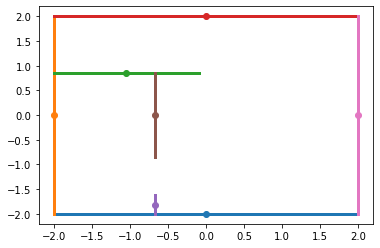

In [176]:
scale = [4,4] # m


walls_centered = walls.copy().astype(np.float32)



for i in range(2):
    walls_centered[:,:,i] = scale[i] * np.true_divide(walls_centered[:,:,i] - walls_centered[:,:,i].min(), walls_centered[:,:,i].max() - walls_centered[:,:,i].min())
    walls_centered[:,:,i] = walls_centered[:,:,i] - walls_centered[:,:,i].max()//2


for wall in walls_centered:
    plt.plot(wall[:,0], wall[:,1], linewidth = 3)
    
    wall_center = np.array([wall[:,0].mean(), wall[:,1].mean()])
    wall_length = np.array([ (wall[:,0].max() - wall[:,0].min())/2, (wall[:,1].max() - wall[:,1].min())/2 ])
        
    
    plt.scatter(wall_center[0], wall_center[1])



# Create URDF

In [200]:
def writeLine(f, line):
    f.write(line + '\n')
    
def writeURDFfile(walls, name = 'room', package = "catbot_pybullet", wall_height = 1, wall_thickness = 0.2, frame_ref = 'odom_link'):
    URDF_DIR = rospack.get_path(package) + '/worlds/'
    
    
        
    f = open(URDF_DIR + name + '.urdf', 'w')
    
    writeLine(f, '<?xml version="1.0"?>')
    writeLine(f, '<robot name="' + name + '">')
    
    color = np.array([255, 165, 0, 255])/255

    
    writeLine(f, '\n\n\n')
    writeLine(f, '<material name="custom_color">')
    writeLine(f, '  <color rgba="{:.1f} {:.1f} {:.1f} {:.1f}"/>'.format(color[0], color[1], color[2], color[3]   ))
    writeLine(f, '</material>')


    
    writeLine(f, '  <link name="{:s}">'.format(frame_ref))
    writeLine(f, '  </link>')
    writeLine(f, '\n\n\n')

    
    for i in range(len(walls)):
        wall = walls[i]
        wall_center = np.array([wall[:,0].mean(), wall[:,1].mean()])
        wall_length = np.array([ (wall[:,0].max() - wall[:,0].min()), (wall[:,1].max() - wall[:,1].min())])
        
        if wall_length[0] == 0:
            wall_length[0] = wall_thickness
            
        if wall_length[1] == 0:
            wall_length[1] = wall_thickness

            
        
        
        writeLine(f, '  <link name="wall_{:d}">'.format(i))
        writeLine(f, '    <visual>')
        writeLine(f, '      <geometry>')
        writeLine(f, '        <box size="{:.3f} {:.3f} {:.3f}"/>'.format(wall_length[0], wall_length[1], wall_height))
        writeLine(f, '      </geometry>')
        writeLine(f, '      <origin xyz="{:.5f} {:.5f} {:.5f}"/>'.format(0,
                                                                         0,
                                                                         0) )
        writeLine(f, '      <material name="custom_color"/>')

        writeLine(f, '    </visual>')

        writeLine(f, '    <inertial>')
        writeLine(f, '      <origin xyz="{:.3f} {:.3f} {:.3f}" rpy ="{:.3f} {:.3f} {:.3f}"/>'.format(0, 
                                                                                                     0, 
                                                                                                     0,
                                                                                                     0, 
                                                                                                     0, 
                                                                                                     0))
        
        writeLine(f, '      <mass value="{:.3f}"/>'.format(10e3))
        writeLine(f, '      <inertia')
        writeLine(f, '        ixx="{:.5f}" ixy="{:.5f}" ixz="{:.5f}"'.format(1e3,
                                                                             1e3,
                                                                             1e3))
        writeLine(f, '        iyy="{:.5f}" iyz="{:.5f}"'.format(1e3,
                                                                1e3))
        writeLine(f, '        izz="{:.5f}"/>'.format(1e3))        
        writeLine(f, '    </inertial>')


        writeLine(f, '    <collision>')
        writeLine(f, '      <origin xyz="{:.3f} {:.3f} {:.3f}" rpy ="{:.3f} {:.3f} {:.3f}"/>'.format(0, 
                                                                                                     0, 
                                                                                                     0,
                                                                                                     0, 
                                                                                                     0, 
                                                                                                     0))
        writeLine(f, '      <geometry>')
        writeLine(f, '        <box size="{:.3f} {:.3f} {:.3f}"/>'.format(wall_length[0], wall_length[1], wall_height))
        writeLine(f, '      </geometry>')
        writeLine(f, '    </collision>')


        writeLine(f, '  </link>')
        writeLine(f, '')
    

    
    writeLine(f, '\n\n\n')
    
    
    
    for i in range(len(walls)):
        wall = walls[i]
        wall_center = np.array([wall[:,0].mean(), wall[:,1].mean()])
        wall_length = np.array([ (wall[:,0].max() - wall[:,0].min()), (wall[:,1].max() - wall[:,1].min())])
        
        
        writeLine(f, '  <joint name="wall_{:d}_joint" type="fixed" dont_collapse="true">'.format(i) )

        writeLine(f, '    <parent link="{:s}"/>'.format(frame_ref) )
        writeLine(f, '    <child  link="wall_{:d}"/>'.format(i) )
            
        writeLine(f, '    <origin xyz="{:.5f} {:.5f} {:.5f}"/>'.format(wall_center[0],
                                                                       wall_center[1],
                                                                       wall_height/2) )
            
            
        writeLine(f, '  </joint>')
        writeLine(f, '')
        

        
    
    writeLine(f, '</robot>')
    
    f.close()
    
    
writeURDFfile(walls_centered, name = 'room')

In [38]:
top_view = patches.Polygon(world_mesh.vectors[:,0,:2], closed=True)

plt.plot()


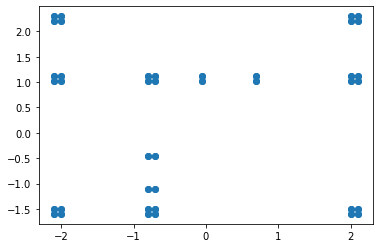

In [26]:
plt.scatter(world_vertices[:,0], world_vertices[:,1])

In [27]:
world_mesh.